# *Relaxation and Decoherence* 

This notebook provides a method of running circuits and measuring hardware parameters of the $T_1$ and $T_2$ decay times for 2 connected qubits. The method of parameter extraction is through solving a Markovian quantum master equation and minimising the least-squares regression between this solution and the experimental data. The notebook is split into two main segments, the experimental circuits and collection of data, followed by the numerical solutions.

## Initialisation Cell

In [1]:
# Plotting
import warnings
from astropy import constants as cnts
from astropy import units as unts
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit.circuit.library import U1Gate, U2Gate
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.visualization import *
from qiskit.visualization import *
from qiskit.tools.jupyter import *
from qiskit import IBMQ
import qiskit
import matplotlib.pyplot as plt
import matplotlib.pylab as pl

# Numerical
import jax
import numpy as np
import jax.numpy as jnp

from jax.numpy.linalg import multi_dot
from jax import jit, vmap, random, jacrev
# from jax.ops import index, index_add, index_update
from jax.experimental.ode import odeint
from numpy import sqrt
import pandas as pd

key = random.PRNGKey(42)

# Qiskit


provider = IBMQ.load_account()

# Constants and Units

# Extras

warnings.filterwarnings("ignore")

# Shows a window in the upper left part with real-time information
# on the status of the jobs running on the IBM Q device
%qiskit_job_watcher


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [2]:
jax.local_devices()

[CpuDevice(id=0)]

## Connect to IBMQ

In [3]:
IBMQ.get_provider(hub='ibm-q',
                  group='open',
                  project='main')
backend = provider.get_backend('ibmq_santiago')

Initialise our parameters

In [4]:
t1l = []
t2l = []

for i in range(len(backend.properties().qubits)):
    t1l.append(backend.properties().t1(i))
    t2l.append(backend.properties().t2(i))

In [5]:
# q0err = backend.properties().readout_error(0)
q0err = 0
print(q0err)
# q1err = backend.properties().readout_error(1)
q1err = 0
print(q1err)

0
0


In [6]:
backend_config = backend.configuration()
backend_prop = backend.properties()

hamiltonian = backend_config.hamiltonian
w0 = hamiltonian['vars']['wq0']
w1 = hamiltonian['vars']['wq1']
w2 = hamiltonian['vars']['wq2']
w3 = hamiltonian['vars']['wq3']
w4 = hamiltonian['vars']['wq4']
j01 = hamiltonian['vars']['jq0q1']
j12 = hamiltonian['vars']['jq1q2']
j23 = hamiltonian['vars']['jq2q3']
j34 = hamiltonian['vars']['jq3q4']

In [7]:
ygate_time = (backend.properties().gate_length('sx', 0) * 2 * unts.s).to(unts.ns)
ygate_time

<Quantity 71.11111111 ns>

In [8]:
qerr = np.sqrt(q0err ** 2 + q1err ** 2) / 2
qerr

0.0

In [9]:
xgate_time = (backend.properties().gate_length('x', 0) * unts.s).to(unts.ns)
xgate_time

<Quantity 35.55555556 ns>

In [10]:
qiskit.circuit.library.YGate(0).decompositions[0].draw()

┌───────────────┐
q_0: ┤ U3(π,π/2,π/2) ├
     └───────────────┘

In [11]:
qiskit.circuit.library.U3Gate(np.pi, np.pi/2, np.pi/2).decompositions[0].draw()

/home/dean/.local/lib/python3.9/site-packages/qiskit/circuit/tools/pi_check.py:55: SymPyDeprecationWarning: 

The expr_free_symbols property is deprecated. Use free_symbols to get
the free symbols of an expression.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-expr-free-symbols
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  syms = expr.expr_free_symbols


┌─────────┐┌────┐┌────────┐┌────┐┌──────────┐
q_0: ┤ Rz(π/2) ├┤ √X ├┤ Rz(2π) ├┤ √X ├┤ Rz(7π/2) ├
     └─────────┘└────┘└────────┘└────┘└──────────┘

In [12]:
(backend.properties().gate_length('rz', 0) * unts.s).to(unts.ns)

<Quantity 0. ns>

In [13]:
qiskit.circuit.library.U2Gate(0, 0).decompositions[0].draw()

┌─────────────┐
q_0: ┤ U3(π/2,0,0) ├
     └─────────────┘

In [14]:
qiskit.circuit.library.U3Gate(np.pi/2, 0, 0).decompositions[0].draw()

global phase: 3π/2
     ┌───────┐┌────┐┌──────────┐┌────┐┌────────┐
q_0: ┤ Rz(0) ├┤ √X ├┤ Rz(3π/2) ├┤ √X ├┤ Rz(3π) ├
     └───────┘└────┘└──────────┘└────┘└────────┘

In [15]:
t2gatetime = 3 * ygate_time
t2gatetime.to(unts.us)

<Quantity 0.21333333 us>

With some helper functions

In [16]:
def expt(T, w):
    """
    This function computes the average number of photons, n, depending on the frequency, w, and the temperature, T.
    Inputs:
    T - Temperature (in Kelvin)
    w - Frequency (in Hz)
    Outputs:
    n - Average photon number
    """
    n = 1/(jnp.exp((cnts.hbar.value * w)/(cnts.k_B.value * T)) - 1)
    return float(n)

In [17]:
def T(w, n):
    """
    This function computes the temperature, T, depending on the frequency, w, and the average number of photons, n.
    Inputs:
    T - Temperature (in Kelvin)
    n - Average photon number
    Outputs:
    w - Frequency (in Hz)
    """
    return cnts.hbar.value * w/(cnts.k_B.value * jnp.log(1/n + 1)) * unts.K

As well as some ansatze for the other parameters, based on the latest configuration $T_1$ & $T_2$ times and the claimed qubit temperatures of 15 mK.

In [18]:
n1 = expt(15e-3, w0)
n2 = expt(15e-3, w1)

t1c = jnp.array(t1l)
t2c = jnp.array(t2l)

g1l = 1/t1c
g2l = 1/t2c

## Generation of coherence circuits

This shows how to generate the circuits. The list of qubits specifies for which qubits to generate characterization circuits; these circuits will run in parallel. The discrete unit of time is the Delay gate, which instructs the circuit to do nothing for a specified amount of time.

In [19]:
time = np.linspace(0, 74*4, 75)
tie = np.linspace(0, 74, 75)

qubits = [0, 1]
shots = 8192

n = len(qubits)
N = 2 ** n

qr = qiskit.QuantumRegister(max(qubits)+1)
cr = qiskit.ClassicalRegister(len(qubits))

nosc = 5

osc_freq = nosc/time[-1]

In [20]:
cool = pl.cm.cool(np.linspace(0, 1, N))
plasma = pl.cm.plasma(np.linspace(0, 1, N + 1))
magma = pl.cm.magma(np.linspace(0, 1, N))
winter = pl.cm.winter(np.linspace(0, 1, N))

In [21]:
def pad_id_gates(circuit, qr, qubit, num_of_id_gates):
    """
    A function for padding a circuit with single-qubit delay gates.
    Args:
        circuit (QuantumCircuit): the quantum circuit that the gates should be
            appended to
        qr (QuantumRegister): the qubit register where the gates should be added
        qubit (int): index of qubit where the gates should be added
        num_of_id_gates (int): the number of delay gates to add
    Returns:
        circuit: The original circuit object, but with delay
            gates added to the qubit register qr at qubit 'qubit'
    """
    
    circuit.barrier(qr[qubit])
    num_of_id_gates = int(num_of_id_gates)
    circuit.delay(num_of_id_gates, qr[qubit], unit = 'us')

    circuit.barrier(qr[qubit])
    return circuit

### T1 Circuits

In [22]:
t1circuits = []

for circ_index, circ_length in enumerate(time):
    circ = qiskit.QuantumCircuit(qr, cr)
    circ.name = 't1circuit_' + str(circ_index) + '_0'
    for _, qubit in enumerate(qubits):
        circ.x(qr[qubit])
        circ = pad_id_gates(circ, qr, qubit, circ_length)
    circ.barrier(qr)
    for qind, qubit in enumerate(qubits):
        circ.measure(qr[qubit], cr[qind])
    t1circuits.append(circ)

In [23]:
t1circuits[-1].draw()

┌───┐ ░ ┌────────────────┐ ░  ░ ┌─┐   
q0_0: ┤ X ├─░─┤ Delay(296[us]) ├─░──░─┤M├───
      ├───┤ ░ ├────────────────┤ ░  ░ └╥┘┌─┐
q0_1: ┤ X ├─░─┤ Delay(296[us]) ├─░──░──╫─┤M├
      └───┘ ░ └────────────────┘ ░  ░  ║ └╥┘
c0: 2/═════════════════════════════════╩══╩═
                                       0  1

### T2* Circuits

In [24]:
t2scircuits = []

for circ_index, circ_length in enumerate(tie * 4):
    circ = qiskit.QuantumCircuit(qr, cr)
    circ.name = 't2starcircuit_' + str(circ_index) + '_0'
    for qind, qubit in enumerate(qubits):
        circ.h(qr[qubit])
        circ = pad_id_gates(circ, qr, qubit, circ_length)
        circ.append(U1Gate(2*np.pi*osc_freq*time[circ_index]), [qr[qubit]])
        circ.h(qr[qubit])
    circ.barrier(qr)
    for qind, qubit in enumerate(qubits):
        circ.measure(qr[qubit], cr[qind])
    t2scircuits.append(circ)

In [25]:
t2scircuits[-1].draw()

┌───┐ ░ ┌────────────────┐ ░ ┌─────────┐┌───┐ ░ ┌─┐   
q0_0: ┤ H ├─░─┤ Delay(296[us]) ├─░─┤ U1(10π) ├┤ H ├─░─┤M├───
      ├───┤ ░ ├────────────────┤ ░ ├─────────┤├───┤ ░ └╥┘┌─┐
q0_1: ┤ H ├─░─┤ Delay(296[us]) ├─░─┤ U1(10π) ├┤ H ├─░──╫─┤M├
      └───┘ ░ └────────────────┘ ░ └─────────┘└───┘ ░  ║ └╥┘
c0: 2/═════════════════════════════════════════════════╩══╩═
                                                       0  1

### T2 Circuits

In [26]:
def t2_circuits(time, qubits, n_echos, phase_alt_echo):
    
    if n_echos < 1:
        raise ValueError('Must be at least one echo')

    xdata = 2 * np.array(time) * n_echos

    qr = qiskit.QuantumRegister(max(qubits)+1)
    cr = qiskit.ClassicalRegister(len(qubits))

    circuits = []

    for circ_index, circ_length in enumerate(time):
        circ = qiskit.QuantumCircuit(qr, cr)
        circ.name = 't2circuit_' + str(circ_index) + '_0'
        for qind, qubit in enumerate(qubits):

            # First Y90 and Y echo
            circ.append(U2Gate(0.0, 0.0), [qr[qubit]])  # Y90
            circ = pad_id_gates(circ, qr, qubit, circ_length)  # ids
            circ.y(qr[qubit])

            for echoid in range(n_echos-1):  # repeat
                circ = pad_id_gates(circ, qr, qubit, 2*circ_length)  # ids
                if phase_alt_echo and (not echoid % 2):  # optionally
                    circ.x(qr[qubit])  # X
                else:
                    circ.y(qr[qubit])

            circ = pad_id_gates(circ, qr, qubit, circ_length)  # ids
            circ.append(U2Gate(0.0, 0.0), [qr[qubit]])  # Y90
        circ.barrier(qr)
        for qind, qubit in enumerate(qubits):
            circ.measure(qr[qubit], cr[qind])  # measure
        circuits.append(circ)

    return circuits

In [27]:
# CPMG Circuits
t2ccircuits = t2_circuits(jnp.floor(time).astype(int), qubits, n_echos = 2, phase_alt_echo = True)
# Echo Circuits
t2ecircuits = t2_circuits(jnp.floor(time).astype(int), qubits, n_echos = 1, phase_alt_echo = False)

In [28]:
t2ccircuits[-1].draw()

┌─────────┐ ░ ┌────────────────┐ ░ ┌───┐ ░ ┌────────────────┐ ░ ┌───┐ ░ »
q1_0: ┤ U2(0,0) ├─░─┤ Delay(296[us]) ├─░─┤ Y ├─░─┤ Delay(592[us]) ├─░─┤ X ├─░─»
      ├─────────┤ ░ ├────────────────┤ ░ ├───┤ ░ ├────────────────┤ ░ ├───┤ ░ »
q1_1: ┤ U2(0,0) ├─░─┤ Delay(296[us]) ├─░─┤ Y ├─░─┤ Delay(592[us]) ├─░─┤ X ├─░─»
      └─────────┘ ░ └────────────────┘ ░ └───┘ ░ └────────────────┘ ░ └───┘ ░ »
c1: 2/════════════════════════════════════════════════════════════════════════»
                                                                              »
«      ┌────────────────┐ ░ ┌─────────┐ ░ ┌─┐   
«q1_0: ┤ Delay(296[us]) ├─░─┤ U2(0,0) ├─░─┤M├───
«      ├────────────────┤ ░ ├─────────┤ ░ └╥┘┌─┐
«q1_1: ┤ Delay(296[us]) ├─░─┤ U2(0,0) ├─░──╫─┤M├
«      └────────────────┘ ░ └─────────┘ ░  ║ └╥┘
«c1: 2/════════════════════════════════════╩══╩═
«                                          0  1

In [29]:
t2ecircuits[-1].draw()

┌─────────┐ ░ ┌────────────────┐ ░ ┌───┐ ░ ┌────────────────┐ ░ »
q2_0: ┤ U2(0,0) ├─░─┤ Delay(296[us]) ├─░─┤ Y ├─░─┤ Delay(296[us]) ├─░─»
      ├─────────┤ ░ ├────────────────┤ ░ ├───┤ ░ ├────────────────┤ ░ »
q2_1: ┤ U2(0,0) ├─░─┤ Delay(296[us]) ├─░─┤ Y ├─░─┤ Delay(296[us]) ├─░─»
      └─────────┘ ░ └────────────────┘ ░ └───┘ ░ └────────────────┘ ░ »
c2: 2/════════════════════════════════════════════════════════════════»
                                                                      »
«      ┌─────────┐ ░ ┌─┐   
«q2_0: ┤ U2(0,0) ├─░─┤M├───
«      ├─────────┤ ░ └╥┘┌─┐
«q2_1: ┤ U2(0,0) ├─░──╫─┤M├
«      └─────────┘ ░  ║ └╥┘
«c2: 2/═══════════════╩══╩═
«                     0  1

### Readout Error Mitigation

In [30]:
meas_calibs, state_labels = complete_meas_cal(qubit_list=qubits, qr=qr, circlabel='mcal')

## Backend Execution

In [31]:
# Run the Readout Error Mitigation circuits
cal_results = qiskit.execute(meas_calibs, backend = backend, shots = shots).result()

In [32]:
# Run the T1 circuits
t1_backend_result = qiskit.execute(t1circuits, backend, shots = shots, optimization_level = 0).result()

In [33]:
# Run the T2* circuits
t2star_backend_result = qiskit.execute(t2scircuits, backend, shots = shots, optimization_level = 0).result()

In [34]:
# Run the T2 Echo circuits
# t2e_backend_result = qiskit.execute(t2ecircuits, backend, shots = shots, optimization_level = 0).result()
t2e_backend_result = qiskit.execute(t2ecircuits, backend, shots = shots, optimization_level = 0).result()

In [35]:
# Run the T2 CPMG circuits
t2c_backend_result = qiskit.execute(t2ccircuits, backend, shots = shots, optimization_level = 0).result()

Let's look at the calibration results

Average Measurement Fidelity: 0.928284


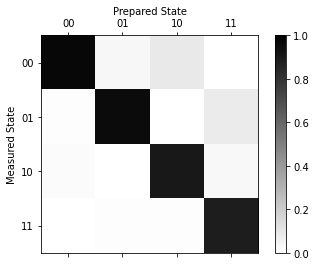

In [36]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel = 'mcal')
print("Average Measurement Fidelity: %f" % meas_fitter.readout_fidelity())
meas_fitter.plot_calibration()

Apply the error mitigation

In [37]:
# Results without mitigation
t1_raw_counts = t1_backend_result.get_counts(0)
t2s_raw_counts = t2star_backend_result.get_counts(0)
t2e_raw_counts = t2e_backend_result.get_counts(0)
t2c_raw_counts = t2c_backend_result.get_counts(0)

# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation

t1_mitigated_results = meas_filter.apply(t1_backend_result)
t2s_mitigated_results = meas_filter.apply(t2star_backend_result)
t2e_mitigated_results = meas_filter.apply(t2e_backend_result)
t2c_mitigated_results = meas_filter.apply(t2c_backend_result)

t1_mitigated_counts = t1_mitigated_results.get_counts(0)
t2s_mitigated_counts = t2s_mitigated_results.get_counts(0)
t2e_mitigated_counts = t2e_mitigated_results.get_counts(0)
t2c_mitigated_counts = t2c_mitigated_results.get_counts(0)

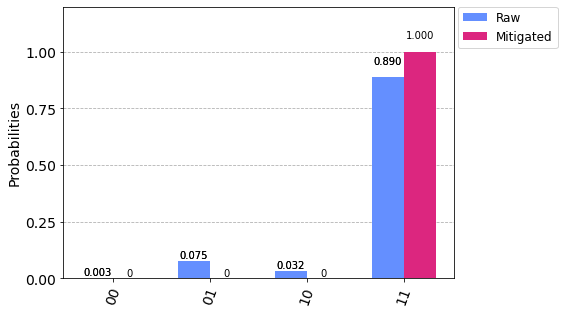

In [38]:
# T1 Mitigated Counts
plot_histogram([t1_raw_counts, t1_mitigated_counts], legend = ['Raw', 'Mitigated'])

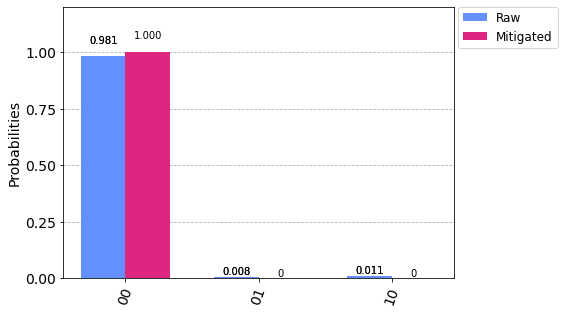

In [39]:
# T2* Mitigated Counts
plot_histogram([t2s_raw_counts, t2s_mitigated_counts], legend = ['Raw', 'Mitigated'])

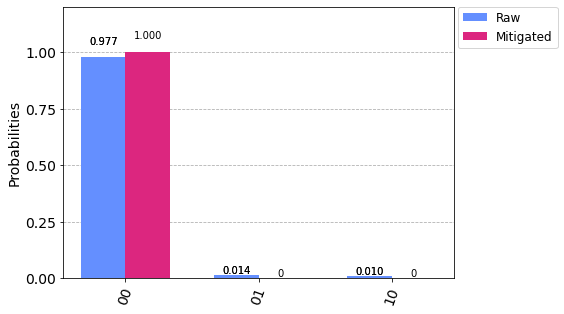

In [40]:
# T2 Echo Mitigated Counts
plot_histogram([t2e_raw_counts, t2e_mitigated_counts], legend = ['Raw', 'Mitigated'])

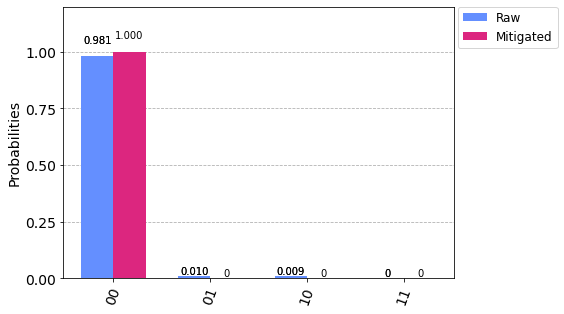

In [41]:
# T2 CPMG Mitigated Counts
plot_histogram([t2c_raw_counts, t2c_mitigated_counts], legend = ['Raw', 'Mitigated'])

## Data Fitting

In [42]:
# T1 Raw

t1raw_lst00 = []
t1raw_lst01 = []
t1raw_lst10 = []
t1raw_lst11 = []

t1ystd00 = []
t1ystd01 = []
t1ystd10 = []
t1ystd11 = []

for i in range(len(time)):
    if '11' in t1_backend_result.get_counts(i):
        i11 = t1_backend_result.get_counts(i)['11']
    else:
        i11 = 0
    if '10' in t1_backend_result.get_counts(i):
        i10 = t1_backend_result.get_counts(i)['10']
    else:
        i10 = 0
    if '01' in t1_backend_result.get_counts(i):
        i01 = t1_backend_result.get_counts(i)['01']
    else:
        i01 = 0
    if '00' in t1_backend_result.get_counts(i):
        i00 = t1_backend_result.get_counts(i)['00']
    else:
        i00 = 0
    
    q00 = i00/shots
    q01 = i01/shots
    q10 = i10/shots
    q11 = i11/shots
    
    q0err
    q1err
    
    t1ystd00.append(np.sqrt(q00 * (1-q00) / shots) + (2 * q0err * q00))
    t1ystd01.append(np.sqrt(q01 * (1-q01) / shots) + (q0err + q1err) * q01)
    t1ystd10.append(np.sqrt(q10 * (1-q10) / shots) + (q1err + q0err) * q10)
    t1ystd11.append(np.sqrt(q11 * (1-q11) / shots) + (2 * q1err * q11))
    
    t1raw_lst00.append(q00)
    t1raw_lst01.append(q01)
    t1raw_lst10.append(q10)
    t1raw_lst11.append(q11)

In [43]:
# T1 Mitigated

t1mit_lst00 = []
t1mit_lst01 = []
t1mit_lst10 = []
t1mit_lst11 = []

for i in range(len(time)):
    if '11' in t1_mitigated_results.get_counts(i):
        i11 = t1_mitigated_results.get_counts(i)['11']
    else:
        i11 = 0
    if '10' in t1_mitigated_results.get_counts(i):
        i10 = t1_mitigated_results.get_counts(i)['10']
    else:
        i10 = 0
    if '01' in t1_mitigated_results.get_counts(i):
        i01 = t1_mitigated_results.get_counts(i)['01']
    else:
        i01 = 0
    if '00' in t1_mitigated_results.get_counts(i):
        i00 = t1_mitigated_results.get_counts(i)['00']
    else:
        i00 = 0
    
    q00 = i00/shots
    q01 = i01/shots
    q10 = i10/shots
    q11 = i11/shots
    
    t1mit_lst00.append(q00)
    t1mit_lst01.append(q01)
    t1mit_lst10.append(q10)
    t1mit_lst11.append(q11)

In [44]:
# T2* Raw

t2sraw_lst00 = []
t2sraw_lst01 = []
t2sraw_lst10 = []
t2sraw_lst11 = []

for i in range(len(time)):
    if '00' in t2star_backend_result.get_counts(i):
        i00 = t2star_backend_result.get_counts(i)['00']
    else:
        i00 = 0
    if '01' in t2star_backend_result.get_counts(i):
        i01 = t2star_backend_result.get_counts(i)['01']
    else:
        i01 = 0
    if '10' in t2star_backend_result.get_counts(i):
        i10 = t2star_backend_result.get_counts(i)['10']
    else:
        i10 = 0
    if '11' in t2star_backend_result.get_counts(i):
        i11 = t2star_backend_result.get_counts(i)['11']
    else:
        i11 = 0
    
    q00 = i00/shots
    q01 = i01/shots
    q10 = i10/shots
    q11 = i11/shots
    
    t2sraw_lst00.append(q00)
    t2sraw_lst01.append(q01)
    t2sraw_lst10.append(q10)
    t2sraw_lst11.append(q11)

In [45]:
# T2* Mitigated

t2smit_lst00 = []
t2smit_lst01 = []
t2smit_lst10 = []
t2smit_lst11 = []

for i in range(len(time)):
    if '00' in t2s_mitigated_results.get_counts(i):
        i00 = t2s_mitigated_results.get_counts(i)['00']
    else:
        i00 = 0
    if '01' in t2s_mitigated_results.get_counts(i):
        i01 = t2s_mitigated_results.get_counts(i)['01']
    else:
        i01 = 0
    if '10' in t2s_mitigated_results.get_counts(i):
        i10 = t2s_mitigated_results.get_counts(i)['10']
    else:
        i10 = 0
    if '11' in t2s_mitigated_results.get_counts(i):
        i11 = t2s_mitigated_results.get_counts(i)['11']
    else:
        i11 = 0
    
    q00 = i00/shots
    q01 = i01/shots
    q10 = i10/shots
    q11 = i11/shots
    
    t2smit_lst00.append(q00)
    t2smit_lst01.append(q01)
    t2smit_lst10.append(q10)
    t2smit_lst11.append(q11)

In [46]:
# T2E Raw

t2eraw_lst00 = []
t2eraw_lst01 = []
t2eraw_lst10 = []
t2eraw_lst11 = []

for i in range(len(time)):
    if '00' in t2e_backend_result.get_counts(i):
        i00 = t2e_backend_result.get_counts(i)['00']
    else:
        i00 = 0
    if '01' in t2e_backend_result.get_counts(i):
        i01 = t2e_backend_result.get_counts(i)['01']
    else:
        i01 = 0
    if '10' in t2e_backend_result.get_counts(i):
        i10 = t2e_backend_result.get_counts(i)['10']
    else:
        i10 = 0
    if '11' in t2e_backend_result.get_counts(i):
        i11 = t2e_backend_result.get_counts(i)['11']
    else:
        i11 = 0
    
    q00 = i00/shots
    q01 = i01/shots
    q10 = i10/shots
    q11 = i11/shots
    
    t2eraw_lst00.append(q00)
    t2eraw_lst01.append(q01)
    t2eraw_lst10.append(q10)
    t2eraw_lst11.append(q11)

In [47]:
# T2E Mitigated

t2emit_lst00 = []
t2emit_lst01 = []
t2emit_lst10 = []
t2emit_lst11 = []

for i in range(len(time)):
    if '00' in t2e_mitigated_results.get_counts(i):
        i00 = t2e_mitigated_results.get_counts(i)['00']
    else:
        i00 = 0
    if '01' in t2e_mitigated_results.get_counts(i):
        i01 = t2e_mitigated_results.get_counts(i)['01']
    else:
        i01 = 0
    if '10' in t2e_mitigated_results.get_counts(i):
        i10 = t2e_mitigated_results.get_counts(i)['10']
    else:
        i10 = 0
    if '11' in t2e_mitigated_results.get_counts(i):
        i11 = t2e_mitigated_results.get_counts(i)['11']
    else:
        i11 = 0
    
    q00 = i00/shots
    q01 = i01/shots
    q10 = i10/shots
    q11 = i11/shots
    
    t2emit_lst00.append(q00)
    t2emit_lst01.append(q01)
    t2emit_lst10.append(q10)
    t2emit_lst11.append(q11)

In [48]:
# T2 CPMG Raw

t2craw_lst00 = []
t2craw_lst01 = []
t2craw_lst10 = []
t2craw_lst11 = []

for i in range(len(time)):
    if '00' in t2c_backend_result.get_counts(i):
        i00 = t2c_backend_result.get_counts(i)['00']
    else:
        i00 = 0
    if '01' in t2c_backend_result.get_counts(i):
        i01 = t2c_backend_result.get_counts(i)['01']
    else:
        i01 = 0
    if '10' in t2c_backend_result.get_counts(i):
        i10 = t2c_backend_result.get_counts(i)['10']
    else:
        i10 = 0
    if '11' in t2c_backend_result.get_counts(i):
        i11 = t2c_backend_result.get_counts(i)['11']
    else:
        i11 = 0
    
    q00 = i00/shots
    q01 = i01/shots
    q10 = i10/shots
    q11 = i11/shots
    
    t2craw_lst00.append(q00)
    t2craw_lst01.append(q01)
    t2craw_lst10.append(q10)
    t2craw_lst11.append(q11)

In [49]:
# T2 CPMG Mitigated

t2cmit_lst00 = []
t2cmit_lst01 = []
t2cmit_lst10 = []
t2cmit_lst11 = []

for i in range(len(time)):
    if '00' in t2c_mitigated_results.get_counts(i):
        i00 = t2c_mitigated_results.get_counts(i)['00']
    else:
        i00 = 0
    if '01' in t2c_mitigated_results.get_counts(i):
        i01 = t2c_mitigated_results.get_counts(i)['01']
    else:
        i01 = 0
    if '10' in t2c_mitigated_results.get_counts(i):
        i10 = t2c_mitigated_results.get_counts(i)['10']
    else:
        i10 = 0
    if '11' in t2c_mitigated_results.get_counts(i):
        i11 = t2c_mitigated_results.get_counts(i)['11']
    else:
        i11 = 0
    
    q00 = i00/shots
    q01 = i01/shots
    q10 = i10/shots
    q11 = i11/shots
    
    t2cmit_lst00.append(q00)
    t2cmit_lst01.append(q01)
    t2cmit_lst10.append(q10)
    t2cmit_lst11.append(q11)

## Plot the $T_1$ Results

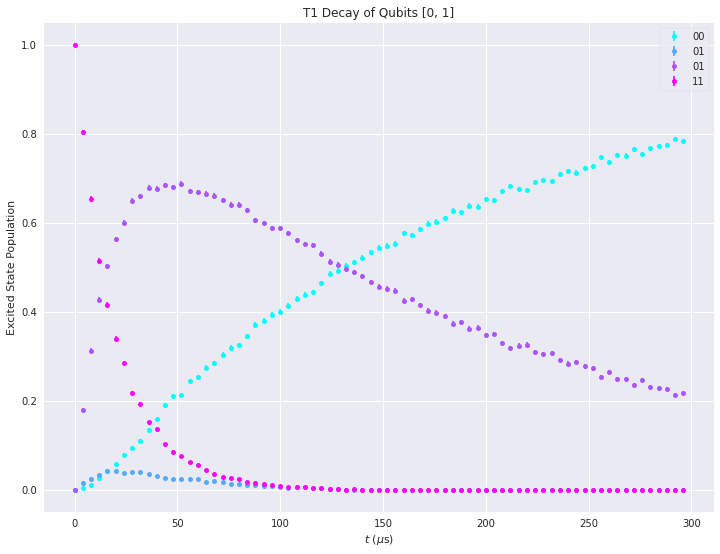

In [50]:
%matplotlib inline
plt.style.use('seaborn')
# matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
fig, ax = plt.subplots(figsize=(12, 9))

plt.title(f'T1 Decay of Qubits {qubits}')
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('Excited State Population')
plt.ylim(-0.05, 1.05)

plt.errorbar(time, t1mit_lst00, t1ystd00, label = "00", marker='.', markersize=10, linestyle='', c = cool[0])
plt.errorbar(time, t1mit_lst01, t1ystd01, label = "01", marker='.', markersize=10, linestyle='', c = cool[1])
plt.errorbar(time, t1mit_lst10, t1ystd10, label = "01", marker='.', markersize=10, linestyle='', c = cool[2])
plt.errorbar(time, t1mit_lst11, t1ystd11, label = "11", marker='.', markersize=10, linestyle='', c = cool[3])

plt.legend(loc = "best", numpoints = 1, frameon = True)
    
plt.show()

## Plot the $T_2^*$ Results

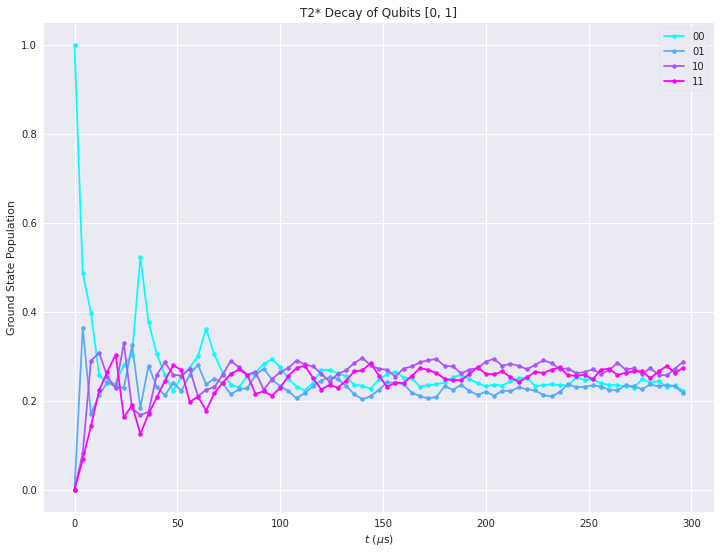

In [51]:
%matplotlib inline
plt.style.use('seaborn')
# matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
fig, ax = plt.subplots(figsize=(12, 9))

plt.title(f'T2* Decay of Qubits {qubits}')
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('Ground State Population')
plt.ylim(-0.05, 1.05)

plt.plot(time, t2smit_lst00, label = "00", marker='.', markersize=9, c = cool[0])
plt.plot(time, t2smit_lst01, label = "01", marker='.', markersize=9, c = cool[1])
plt.plot(time, t2smit_lst10, label = "10", marker='.', markersize=9, c = cool[2])
plt.plot(time, t2smit_lst11, label = "11", marker='.', markersize=9, c = cool[3])

plt.legend(loc = "best", numpoints = 1, frameon = True)
    
plt.show()

## Plot the $T_2$ Echo Results

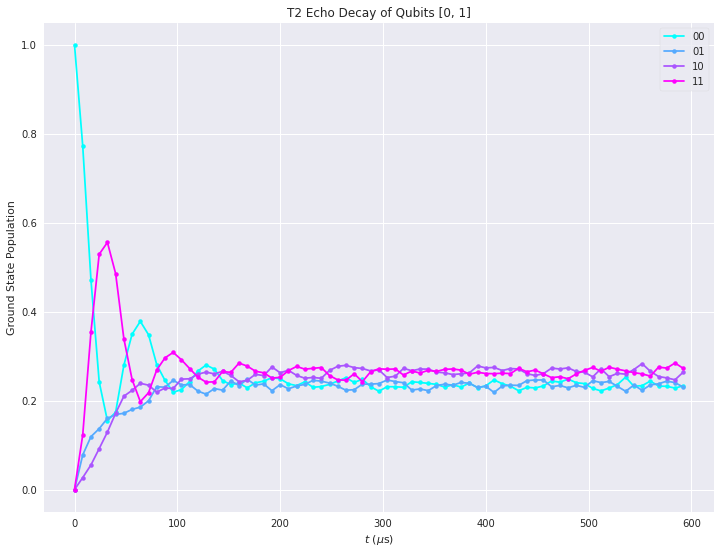

In [52]:
%matplotlib inline
plt.style.use('seaborn')
# matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
fig, ax = plt.subplots(figsize=(12, 9))

plt.title(f'T2 Echo Decay of Qubits {qubits}')
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('Ground State Population')
plt.ylim(-0.05, 1.05)

plt.plot(time * 2, t2emit_lst00, label = "00", marker='.', markersize=9, c = cool[0])
plt.plot(time * 2, t2emit_lst01, label = "01", marker='.', markersize=9, c = cool[1])
plt.plot(time * 2, t2emit_lst10, label = "10", marker='.', markersize=9, c = cool[2])
plt.plot(time * 2, t2emit_lst11, label = "11", marker='.', markersize=9, c = cool[3])

plt.legend(loc = "best", numpoints = 1, frameon = True)
    
plt.show()

In [53]:
# import csv

# rows_t2e_00 = zip(time*2, t2emit_lst00)
# rows_t2e_10 = zip(time*2, t2emit_lst10)
# rows_t2e_01 = zip(time*2, t2emit_lst01)
# rows_t2e_11 = zip(time*2, t2emit_lst11)

# with open('Q2_T2e_raw00.csv', "w") as a:
#     writer = csv.writer(a)
#     for row in rows_t2e_00:
#         writer.writerow(row)

# with open('Q2_T2e_raw10.csv', "w") as a:
#     writer = csv.writer(a)
#     for row in rows_t2e_10:
#         writer.writerow(row)

# with open('Q2_T2e_raw01.csv', "w") as a:
#     writer = csv.writer(a)
#     for row in rows_t2e_01:
#         writer.writerow(row)

# with open('Q2_T2e_raw11.csv', "w") as a:
#     writer = csv.writer(a)
#     for row in rows_t2e_11:
#         writer.writerow(row)

## Plot the $T_2$ CPMG Results

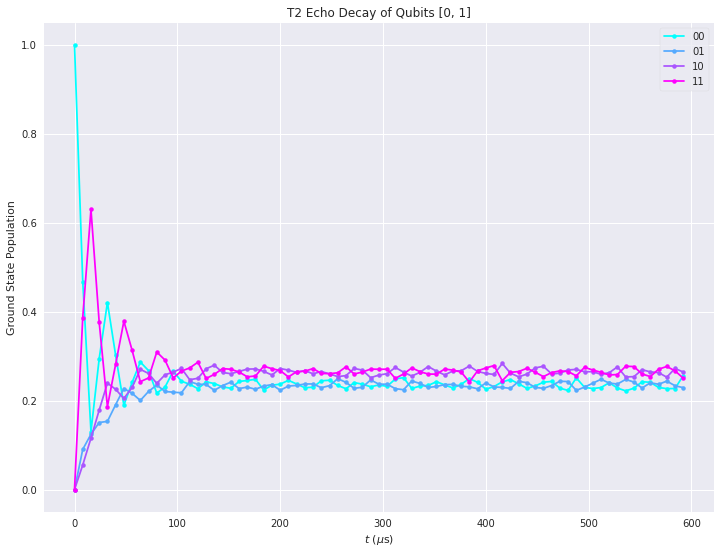

In [54]:
%matplotlib inline
plt.style.use('seaborn')
# matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
fig, ax = plt.subplots(figsize=(12, 9))

plt.title(f'T2 Echo Decay of Qubits {qubits}')
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('Ground State Population')
plt.ylim(-0.05, 1.05)

plt.plot(time * 2, t2cmit_lst00, label = "00", marker='.', markersize=9, c = cool[0])
plt.plot(time * 2, t2cmit_lst01, label = "01", marker='.', markersize=9, c = cool[1])
plt.plot(time * 2, t2cmit_lst10, label = "10", marker='.', markersize=9, c = cool[2])
plt.plot(time * 2, t2cmit_lst11, label = "11", marker='.', markersize=9, c = cool[3])

plt.legend(loc = "best", numpoints = 1, frameon = True)
    
plt.show()

# Numerical Solutions

In [55]:
sz = jnp.array([[1,0],[0,-1]], dtype = jnp.complex64)
sx = jnp.array([[0,1],[1,0]], dtype = jnp.complex64)
sy = jnp.array([[0, -1j],[1j, 0]], dtype = jnp.complex64)

sp = jnp.array([[0,1],[0,0]], dtype = jnp.complex64)
sm = jnp.array([[0,0],[1,0]], dtype = jnp.complex64)

zero = jnp.array([1, 0], dtype = jnp.complex64)
one = jnp.array([0, 1], dtype = jnp.complex64)
plus = 1/jnp.sqrt(2) * jnp.array([1, 1], dtype = jnp.complex64)
minus = 1/jnp.sqrt(2) * jnp.array([1, -1], dtype = jnp.complex64)
right = 1/jnp.sqrt(2) * (zero + 1j * one)
left = 1/jnp.sqrt(2) * (zero - 1j * one)

id2 = jnp.identity(2, dtype = jnp.complex64)
id4 = jnp.kron(id2, id2)

sz1 = jnp.kron(sz, id2)
sx1 = jnp.kron(sx, id2)
sy1 = jnp.kron(sy, id2)
sp1 = jnp.kron(sp, id2)
sm1 = jnp.kron(sm, id2)

sz2 = jnp.kron(id2, sz)
sx2 = jnp.kron(id2, sx)
sy2 = jnp.kron(id2, sy)
sp2 = jnp.kron(id2, sp)
sm2 = jnp.kron(id2, sm)

O1 = (jnp.identity(4) - sz1)/2
O2 = (jnp.identity(4) - sz2)/2

H2 = 1/jnp.sqrt(2) * jnp.array([[1, 1],
                                [1, -1]], dtype = jnp.complex64)

H4 = np.kron(H2, H2)

def ugate(t, p, l):
    u = jnp.array([[jnp.cos(t/2), - jnp.exp(1j * l) * jnp.sin(t/2)],
                  [jnp.exp(1j * p) * jnp.sin(t/2), jnp.exp(1j * (p + l)) * jnp.cos(t/2)]], dtype = jnp.complex64)
    return u

def u1gate(l):
    u = jnp.array([[1, 0],
                  [0, jnp.exp(1j * l)]], dtype = jnp.complex64)
    return u

def u2gate(p, l):
    u = 1/jnp.sqrt(2) * jnp.array([[1, -jnp.exp(1j * l)],
                                   [jnp.exp(1j * p), jnp.exp(1j * (p + l))]], dtype = jnp.complex64)
    return u

def dagger(A):
    return jnp.transpose(jnp.conjugate(A))

Y90 = jnp.kron(u2gate(0, 0), u2gate(0, 0))

X = jnp.kron(sx, sx)
Y = jnp.kron(sy, sy)

xdata = time / 1e6

We will solve the following equation. The Quantum Master equation for a two-qubit system undergoing thermal relaxation and decoherence:
$$\frac{d \rho}{dt}=\mathcal{L}\rho,$$
where
$$\mathcal{L}\rho =-\imath[H,\rho]+\gamma_1(\langle n_1 \rangle +1)\left(\sigma_-^1\rho\sigma_+^1+\frac{1}{2}\left\{\sigma_+^1\sigma_-^1,\rho\right\}\right) + \gamma_1(\langle n_1 \rangle)\left(\sigma_+^1\rho\sigma_-^1+\frac{1}{2}\left\{\sigma_-^1\sigma_+^1,\rho\right\}\right) \\ + \gamma_2(\langle n_2 \rangle +1)\left(\sigma_-^2\rho\sigma_+^2+\frac{1}{2}\left\{\sigma_+^2\sigma_-^2,\rho\right\}\right) + \gamma_2(\langle n_2 \rangle)\left(\sigma_+^2\rho\sigma_-^1+\frac{1}{2}\left\{\sigma_-^1\sigma_+^2,\rho\right\}\right) \\ + \gamma_z^0 \left( \sigma_z^0 \rho \sigma_z^0 - \rho \right) + \gamma_z^1 \left( \sigma_z^1 \rho \sigma_z^1 - \rho \right)$$

and
$$
H = \frac{\omega_1}{2}\sigma_z^1 + \frac{\omega_2}{2}\sigma_z^2 + J\left(\sigma_+\sigma_- + \sigma_-\sigma_+\right)
$$

$$
\gamma_1^1 = \gamma\left(\langle n_1 \rangle + 1\right)  \qquad\qquad \gamma_2^1 = \gamma\left(\langle n_1 \rangle\right)
$$

$$
\gamma_1^2 = \gamma\left(\langle n_2 \rangle + 1\right)  \qquad\qquad \gamma_2^2 = \gamma\left(\langle n_2 \rangle\right)
$$

$$
\langle n_x \rangle=\frac{1}{e^{\hbar\omega_x/kT}-1} \qquad\qquad x \in \{1, 2\}
$$

The initial condition of the $T_1$ solution is:
$$\rho(0)=|00\rangle\langle 00|,$$
where 
$$|0\rangle=\left(\begin{matrix}
1\\
0
\end{matrix}\right)$$

$$
\rho_0 = \begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
\end{pmatrix}
$$

The initial condition for the $T_2^*$ solution is:
$$\rho(0)=|++\rangle\langle ++|,$$
where 
$$|+\rangle=\frac{1}{\sqrt{2}}\left(\begin{matrix}
1\\
1
\end{matrix}\right)$$

$$
\rho_0 = \frac{1}{4} \begin{pmatrix}
1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1 \\
\end{pmatrix}
$$

In [56]:
init = jnp.array(jnp.outer(jnp.kron(plus, plus), jnp.kron(plus, plus)), dtype = jnp.complex64)

inio = jnp.array(jnp.outer(jnp.kron(zero, zero), jnp.kron(zero, zero)), dtype = jnp.complex64)

ini1 = jnp.array(jnp.outer(jnp.kron(one, one), jnp.kron(one, one)), dtype = jnp.complex64)

inim = jnp.array(jnp.outer(jnp.kron(minus, minus), jnp.kron(minus, minus)), dtype = jnp.complex64)

inid = jnp.array(jnp.outer(jnp.kron(plus, minus), jnp.kron(plus, minus)), dtype = jnp.complex64)

inip = jnp.array(jnp.outer(jnp.kron(minus, plus), jnp.kron(minus, plus)), dtype = jnp.complex64)

iniP = jnp.array(jnp.outer(jnp.kron(plus, plus), jnp.kron(minus, minus)), dtype = jnp.complex64)

inir = jnp.array(jnp.outer(jnp.kron(right, right), jnp.kron(right, right)), dtype = jnp.complex64)

inil = jnp.array(jnp.outer(jnp.kron(left, left), jnp.kron(left, left)), dtype = jnp.complex64)

inix = jnp.diag(jnp.array([0.25, 0.25, 0.25, 0.25]))

In [57]:
xdata = time / 1e6
xd = time/1e3
qtime = jnp.linspace(0, 0.075, 75)
prmsl = [w1, w2, g1l[0], g1l[1], j01, n1, n2]
# prms1 = jnp.array([w0, w1, g1l[0] * 1e6, g1l[1] * 1e6, j01, n1, n2]) / 1e9
# prms2s = jnp.array([w0, w1, 6 * g2l[0] * 1e6, 6 * g2l[1] * 1e6, j01, n1, n2]) / 1e9
# prms2e = jnp.array([w0, w1, g2l[0] * 1e6, g2l[1] * 1e6, j01, n1, n2]) / 1e9

# prms1 = jnp.array([g1l[0] * 1e6, g1l[1] * 1e6, j01, n1, n2]) / 1e9
# prms2s = jnp.array([6 * g2l[0] * 1e6, 6 * g2l[1] * 1e6, j01, n1, n2]) / 1e9
# prmsl_hc = jnp.array([g1l[0] * 1e6, g1l[1] * 1e6, j01 * 1e4, n1, n2]) / 1e9
# prms2e = jnp.array([g2l[0] * 1e6, g2l[1] * 1e6, j01, n1, n2]) / 1e9

prms1 = jnp.array([g1l[0] * 1e6, g1l[1] * 1e6, 0, 0, j01, n1, n2]) / 1e9
prms2s = jnp.array([6 * g2l[0] * 1e6, 6 * g2l[1]
                   * 1e6, 0, 0, j01, n1, n2]) / 1e9
prmsl_hc = jnp.array(
    [g1l[0] * 1e6, g1l[1] * 1e6, j01 * 1e4, 0, 0, n1, n2]) / 1e9
prms2e = jnp.array([g2l[0] * 1e6, g2l[1] * 1e6, 0, 0, j01, n1, n2]) / 1e9


## Define the Master Equation Solvers

In [58]:
# Function for the T1 Solution

@jit
def func_t1(r, cg1, cg2, cz1, cz2, jc, pn1, pn2):

    W1 = w1 / 1e9
    W2 = w2 / 1e9

    def LinEm(x, t, omega1=W1, omega2=W2, gamma1=cg1, gamma2=cg2, gammaz1=cz1, gammaz2=cz2, J=jc, N1=pn1, N2=pn2):
        x = x.reshape(4,4)
        H = omega1/2 * sz1 + omega2/2 * sz2 + J*(jnp.kron(sp, sm) + jnp.kron(sm, sp))
        res = -1j*(jnp.dot(H, x) - jnp.dot(x, H))
        res += gamma1*(N1 + 1)*(multi_dot([sm1,x,sp1])-0.5*multi_dot([sp1,sm1,x])-0.5*multi_dot([x,sp1,sm1]))
        res += gamma1*(N1)*(multi_dot([sp1,x,sm1])-0.5*multi_dot([sm1,sp1,x])-0.5*multi_dot([x,sm1,sp1]))
        res += gamma2*(N2 + 1)*(multi_dot([sm2,x,sp2])-0.5*multi_dot([sp2,sm2,x])-0.5*multi_dot([x,sp2,sm2]))
        res += gamma2*(N2)*(multi_dot([sp2, x, sm2])-0.5 *
                            multi_dot([sm2, sp2, x])-0.5*multi_dot([x, sm2, sp2]))
        res += gammaz1 * (multi_dot([sz1, x, sz1]) - x)
        res += gammaz2 * (multi_dot([sz2, x, sz2]) - x)
        return res.ravel().astype(jnp.complex64)

    # sol = jnp.zeros((len(r),4,4),dtype=jnp.complex64)
    solint = jnp.array(odeint(LinEm,
                                    y0 = inio.ravel(),
                                    t = r).reshape(len(r), 4, 4), dtype=jnp.complex64)

    # for step in range(len(r)):
    #     sol = index_update(sol,
    #                        index[step],
    #                        solint[step])

    return solint

In [59]:
# Function for the T2* Solution

@jit
def func_t2s(r, cg1, cg2, cz1, cz2, jc, pn1, pn2):

    W1 = w1 / 1e9
    W2 = w2 / 1e9
    
    def LinEm(x, t, omega1=W1, omega2=W2, gamma1=cg1, gamma2=cg2, gammaz1=cz1, gammaz2=cz2, J=jc, N1=pn1, N2=pn2):
        x = x.reshape(4,4)
        H = omega1/2 * sz1 + omega2/2 * sz2 + J*(jnp.kron(sp, sm) + jnp.kron(sm, sp))
        res = -1j*(jnp.dot(H, x) - jnp.dot(x, H))
        res += gamma1*(N1 + 1)*(multi_dot([sm1,x,sp1])-0.5*multi_dot([sp1,sm1,x])-0.5*multi_dot([x,sp1,sm1]))
        res += gamma1*(N1)*(multi_dot([sp1,x,sm1])-0.5*multi_dot([sm1,sp1,x])-0.5*multi_dot([x,sm1,sp1]))
        res += gamma2*(N2 + 1)*(multi_dot([sm2,x,sp2])-0.5*multi_dot([sp2,sm2,x])-0.5*multi_dot([x,sp2,sm2]))
        res += gamma2*(N2)*(multi_dot([sp2, x, sm2])-0.5 *
                            multi_dot([sm2, sp2, x])-0.5*multi_dot([x, sm2, sp2]))
        res += gammaz1 * (multi_dot([sz1, x, sz1]) - x)
        res += gammaz2 * (multi_dot([sz2, x, sz2]) - x)
        return res.ravel().astype(jnp.complex64)

    sol = jnp.zeros((len(r),4,4),dtype=jnp.complex64)
    solint = jnp.array(odeint(LinEm,
                                    y0 = init.ravel(),
                                    t = r).reshape(len(r), 4, 4), dtype=jnp.complex64)

    for step in range(len(r)):
        # sol = index_update(sol,
        #                    index[step],
        #                    solint[step])
        sol = sol.at[step].set(solint[step])
    
    solH = jnp.zeros((len(r),4,4),dtype=jnp.complex64)
    
    X = jnp.kron(sx, sx)

    for step in range(len(r)):
        # solH = index_update(solH,
        #                     index[step],
        #                     multi_dot([X, H4, sol[step], H4, X]))
        solH = solH.at[step].set(multi_dot([X, H4, sol[step], H4, X]))

    return solH

In [60]:
# Function for the T2 Echo Solution

@jit
def func_t2e(r, cg1, cg2, cz1, cz2, jc, pn1, pn2):

    W1 = w1 / 1e9
    W2 = w2 / 1e9

    def LinEm(x, t, omega1=W1, omega2=W2, gamma1=cg1, gamma2=cg2, gammaz1=cz1, gammaz2=cz2, J=jc, N1=pn1, N2=pn2):
        x = x.reshape(4,4)
        H = omega1/2 * sz1 + omega2/2 * sz2 + J*(jnp.kron(sp, sm) + jnp.kron(sm, sp))
        res = -1j*(jnp.dot(H, x) - jnp.dot(x, H))
        res += gamma1*(N1 + 1)*(multi_dot([sm1,x,sp1])-0.5*multi_dot([sp1,sm1,x])-0.5*multi_dot([x,sp1,sm1]))
        res += gamma1*(N1)*(multi_dot([sp1,x,sm1])-0.5*multi_dot([sm1,sp1,x])-0.5*multi_dot([x,sm1,sp1]))
        res += gamma2*(N2 + 1)*(multi_dot([sm2,x,sp2])-0.5*multi_dot([sp2,sm2,x])-0.5*multi_dot([x,sp2,sm2]))
        res += gamma2*(N2)*(multi_dot([sp2, x, sm2])-0.5 *
                            multi_dot([sm2, sp2, x])-0.5*multi_dot([x, sm2, sp2]))
        res += gammaz1 * (multi_dot([sz1, x, sz1]) - x)
        res += gammaz2 * (multi_dot([sz2, x, sz2]) - x)
        return res.ravel()

    sol = jnp.zeros((len(r),4,4))
    
    solint1 = jnp.array(odeint(LinEm,
                               y0 = multi_dot([Y90, inio, dagger(Y90)]).ravel(),
                               t = r).reshape(len(r), 4, 4))
    
    solint2 = jnp.zeros((len(r),4,4))
    
    for stp in range(len(r)):
        # solint2 = index_update(solint2,
        #                        index[stp],
        #                        jnp.array(odeint(LinEm,
        #                                         y0 = multi_dot([Y, solint1[stp], Y]).ravel(),
        #                                         t=r)[stp].reshape(4, 4)))
        solint2 = solint2.at[stp].set(jnp.array(odeint(LinEm,
                                                y0=multi_dot(
                                                    [Y, solint1[stp], Y]).ravel(),
                                                t=r)[stp].reshape(4, 4)))

    for step in range(len(r)):
        # sol = index_update(sol,
        #                    index[step],
        #                    multi_dot([Y90, solint2[step], dagger(Y90)]))
        sol = sol.at[step].set(
            multi_dot([Y90, solint2[step], dagger(Y90)]))

    return sol

## Plot the solutions

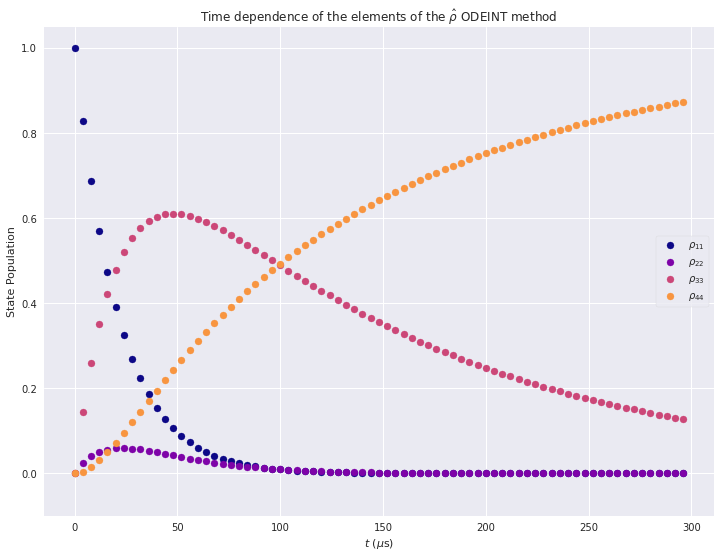

In [61]:
# T1 Solution

%matplotlib inline
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(12, 9))

T1Sols = func_t1(xd, *prms1)

plt.scatter(time, T1Sols[:, 0, 0], label = r'$\rho_{11}$', color = plasma[0])
plt.scatter(time, T1Sols[:, 1, 1], label = r'$\rho_{22}$', color = plasma[1])
plt.scatter(time, T1Sols[:, 2, 2], label = r'$\rho_{33}$', color = plasma[2])
plt.scatter(time, T1Sols[:, 3, 3], label = r'$\rho_{44}$', color = plasma[3])

plt.title('Time dependence of the elements of the '+r'$\hat{\rho}$'+' ODEINT method')
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('State Population')
plt.ylim(-0.1, 1.05)
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

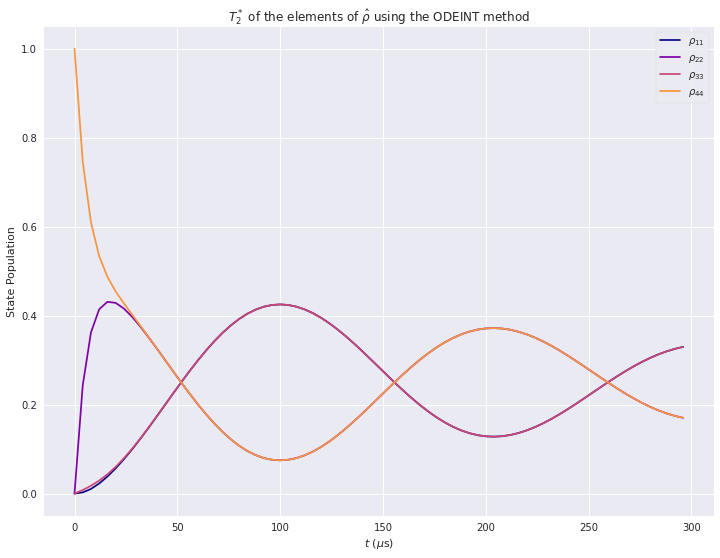

In [62]:
# T2 Star Solution

%matplotlib inline
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(12, 9))

T2sSols = func_t2s(xd, *prmsl_hc)

plt.plot(time, T2sSols[:, 0, 0], label = r'$\rho_{11}$', color = plasma[0])
plt.plot(time, T2sSols[:, 1, 1], label = r'$\rho_{22}$', color = plasma[1])
plt.plot(time, T2sSols[:, 2, 2], label = r'$\rho_{33}$', color = plasma[2])
plt.plot(time, T2sSols[:, 3, 3], label = r'$\rho_{44}$', color = plasma[3])

plt.title(r'$T_2^*$' + ' of the elements of '+r'$\hat{\rho}$'+' using the ODEINT method')
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('State Population')
# plt.ylim(-0.1, 1.05)
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

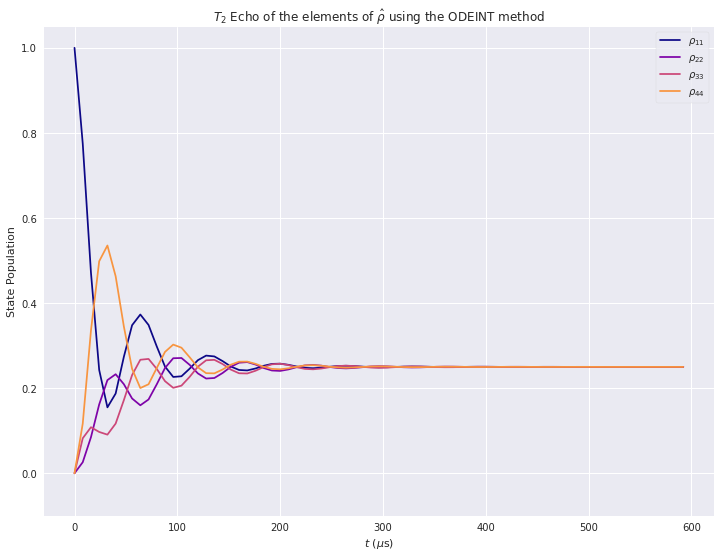

In [63]:
# T2 Echo Solution

%matplotlib inline
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(12, 9))

prmsl_hc = jnp.array([g1l[0] * 1e6, g1l[1] * 1e6, 0, 0, j01 * 1e4, n1, n2]) / 1e9

T2eSols = func_t2e(xd * 1.3, *prmsl_hc)

plt.plot(time * 2, T2eSols[:, 0, 0], label = r'$\rho_{11}$', color = plasma[0])
plt.plot(time * 2, T2eSols[:, 1, 1], label = r'$\rho_{22}$', color = plasma[1])
plt.plot(time * 2, T2eSols[:, 2, 2], label = r'$\rho_{33}$', color = plasma[2])
plt.plot(time * 2, T2eSols[:, 3, 3], label = r'$\rho_{44}$', color = plasma[3])

plt.title(r'$T_2$' + ' Echo of the elements of '+r'$\hat{\rho}$'+' using the ODEINT method')
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('State Population')
plt.ylim(-0.1, 1.05)
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

## Compare the device parameters to the experimental results

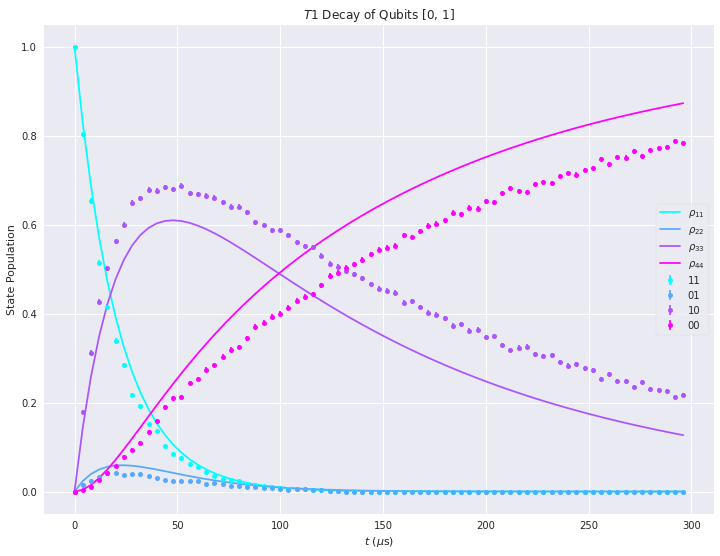

In [64]:
# T1 Solution and Experiments

%matplotlib inline
plt.style.use('seaborn')
# matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
fig, ax = plt.subplots(figsize=(12, 9))

plt.errorbar(time, t1mit_lst11, t1ystd11, label = "11", marker='.', markersize=10, linestyle='', c = cool[0])
plt.errorbar(time, t1mit_lst01, t1ystd01, label = "01", marker='.', markersize=10, linestyle='', c = cool[1])
plt.errorbar(time, t1mit_lst10, t1ystd10, label = "10", marker='.', markersize=10, linestyle='', c = cool[2])
plt.errorbar(time, t1mit_lst00, t1ystd00, label = "00", marker='.', markersize=10, linestyle='', c = cool[3])

plt.plot(time, T1Sols[:, 0, 0], label = r'$\rho_{11}$', color = cool[0])
plt.plot(time, T1Sols[:, 1, 1], label = r'$\rho_{22}$', color = cool[1])
plt.plot(time, T1Sols[:, 2, 2], label = r'$\rho_{33}$', color = cool[2])
plt.plot(time, T1Sols[:, 3, 3], label = r'$\rho_{44}$', color = cool[3])

plt.title(f'$T1$ Decay of Qubits {qubits}')
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('State Population')
plt.ylim(-0.05, 1.05)
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

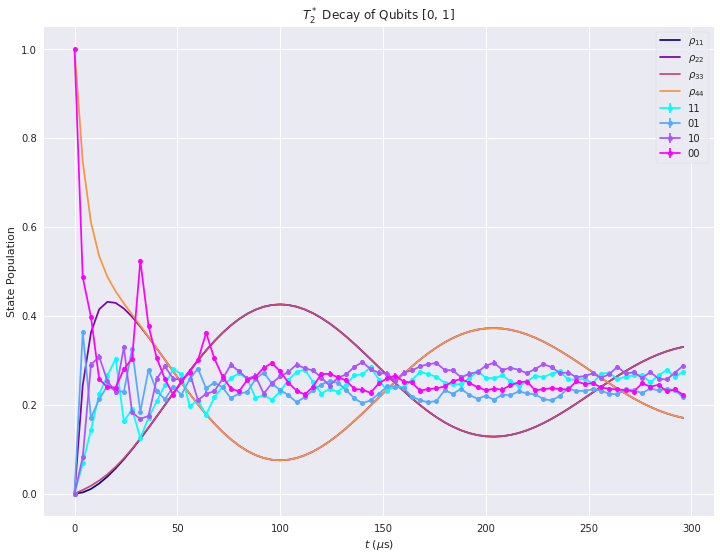

In [65]:
# T2 Star Solution and Experiments

%matplotlib inline
plt.style.use('seaborn')
# matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
fig, ax = plt.subplots(figsize=(12, 9))

plt.errorbar(time, t2smit_lst11, t1ystd11, label = "11", marker='.', markersize=10, c = cool[0])
plt.errorbar(time, t2smit_lst01, t1ystd01, label = "01", marker='.', markersize=10, c = cool[1])
plt.errorbar(time, t2smit_lst10, t1ystd10, label = "10", marker='.', markersize=10, c = cool[2])
plt.errorbar(time, t2smit_lst00, t1ystd00, label = "00", marker='.', markersize=10, c = cool[3])

plt.plot(time, T2sSols[:, 0, 0], label = r'$\rho_{11}$', color = plasma[0])
plt.plot(time, T2sSols[:, 1, 1], label = r'$\rho_{22}$', color = plasma[1])
plt.plot(time, T2sSols[:, 2, 2], label = r'$\rho_{33}$', color = plasma[2])
plt.plot(time, T2sSols[:, 3, 3], label = r'$\rho_{44}$', color = plasma[3])

plt.title(f'$T_2^*$ Decay of Qubits {qubits}')
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('State Population')
plt.ylim(-0.05, 1.05)
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

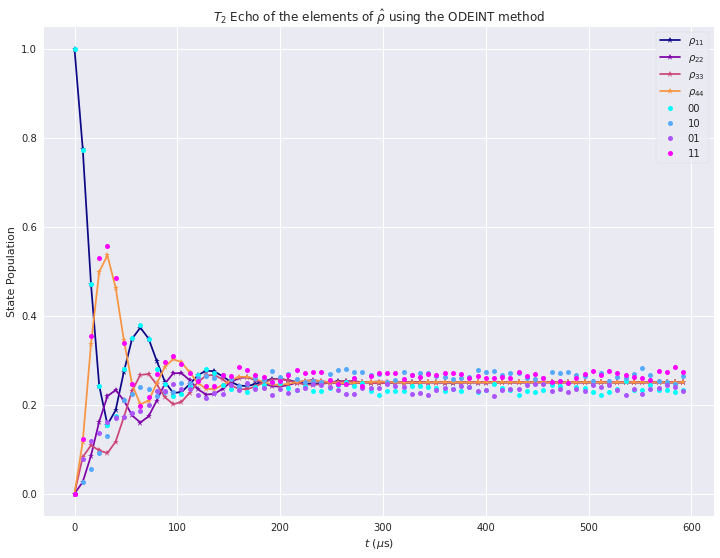

In [66]:
# T2 Echo Solution and Experiments

%matplotlib inline
plt.style.use('seaborn')
# matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
fig, ax = plt.subplots(figsize=(12, 9))

plt.plot(time * 2, T2eSols[:, 0, 0], label = r'$\rho_{11}$', marker='*', color = plasma[0])
plt.plot(time * 2, T2eSols[:, 1, 1], label = r'$\rho_{22}$', marker='*', color = plasma[1])
plt.plot(time * 2, T2eSols[:, 2, 2], label = r'$\rho_{33}$', marker='*', color = plasma[2])
plt.plot(time * 2, T2eSols[:, 3, 3], label = r'$\rho_{44}$', marker='*', color = plasma[3])

plt.plot(time * 2, t2emit_lst00, label = "00", marker='.', linestyle = '', markersize=10, c = cool[0])
plt.plot(time * 2, t2emit_lst10, label = "10", marker='.', linestyle = '', markersize=10, c = cool[1])
plt.plot(time * 2, t2emit_lst01, label = "01", marker='.', linestyle = '', markersize=10, c = cool[2])
plt.plot(time * 2, t2emit_lst11, label = "11", marker='.', linestyle = '', markersize=10, c = cool[3])

plt.title(r'$T_2$' + ' Echo of the elements of '+r'$\hat{\rho}$'+' using the ODEINT method')
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('State Population')
# plt.ylim(-0.1, 1.05)
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

In [67]:
((xd)[-5:] * unts.ms).to(unts.us) * 0.3

<Quantity [84. , 85.2, 86.4, 87.6, 88.8] us>

## Data Optimisation

In [68]:
# Least Squares Function

def mse(observations, estimates):
    '''
    INPUT:
        observations - numpy array of values indicating observed values
        estimates - numpy array of values indicating an estimate of values
    OUTPUT:
        Mean Square Error value
    '''
    
    obav = []
    diff = []
    var = []
    dlen = len(time)
    
    for i in range(N):
        obav.append(sum(observations[i])/dlen)
    
    for d in range(N):
        diff.append(jnp.abs(observations[d] - estimates[d]))
    
    for a in range(N):
        var.append(jnp.abs(observations[a] - obav[a]))
    
    sq_diff = sum(diff) ** 2
    mse = sum(sq_diff)
    vari = sum(sum(var) ** 2)
    r2 = (1 - (mse/vari)) * 100
    
    return mse

In [69]:
def reg(observations, estimates):
    obav = []
    diff = []
    var = []
    dlen = len(time)
    
    for i in range(N):
        obav.append(sum(observations[i])/dlen)
    
    for d in range(N):
        diff.append(jnp.abs(observations[d] - estimates[d]))
    
    for a in range(N):
        var.append(jnp.abs(observations[a] - obav[a]))
    
    sq_diff = sum(diff) ** 2
    mse = sum(sq_diff)
    vari = sum(sum(var) ** 2)
    r2 = (1 - (mse/vari)) * 100
    
    return r2

In [70]:
# Minimise the LstSqrs Function

def minmse(y):
    Y = y[0]
    
    rhot1 = func_t1(xd, *Y)
    
    t1data = jnp.array(t1mit_lst11, dtype=jnp.float64)
    t2data = jnp.array(t1mit_lst01, dtype=jnp.float64)
    t3data = jnp.array(t1mit_lst10, dtype=jnp.float64)
    t4data = jnp.array(t1mit_lst00, dtype=jnp.float64)
    tdata = [t1data, t2data, t3data, t4data]
    
    tst1 = rhot1[:, 0, 0]
    tst2 = rhot1[:, 1, 1]
    tst3 = rhot1[:, 2, 2]
    tst4 = rhot1[:, 3, 3]
    tstd = [tst1, tst2, tst3, tst4]
    
    return mse(tdata, tstd)

In [71]:
minmse(jnp.array([prms1]))

DeviceArray(2.5814078, dtype=float32)

In [72]:
# Define an adam gradient descent optimiser

minfunc = vmap(minmse)

scorelst = []
tlst = []

# bounds = jnp.array([w0, w1, g1l[0], g1l[1], j01, n1, n2], dtype = jnp.float32)

def adam_jack(bound, n_iter, alpha, beta1, beta2, eps=1e-8):
    x = bound
    first = x
    best = x
    worst = x
    score = minfunc(jnp.array([[x]]))
    # score = minmse(jnp.array([x]))
    scbest = score
    print('f(%s) = %f' % (x, score))

    J = jacrev(minmse)

    m = jnp.array([0, 0, 0, 0, 0, 0, 0], dtype = jnp.float32)
    v = jnp.array([0, 0, 0, 0, 0, 0, 0], dtype = jnp.float32)

    for t in range(n_iter + 1):
        # calculate gradient g(t)
        g = J([x])[0]

        m = beta1 * m + (1.0 - beta1) * g
        v = beta2 * v + (1.0 - beta2) * g**2

        mhat = m / (1.0 - beta1**(t+1))
        vhat = v / (1.0 - beta2**(t+1))

        x = x - alpha * mhat / (sqrt(vhat) + eps)

        for i in range(len(x)):
            if x[i] < 0:
                # x = index_update(x, index[i], bound[i])
                x = x.at[i].set(bound[i])

        if scbest > minmse(jnp.array([x])):
            best = x
            scbest = minmse(jnp.array([best]))

        # evaluate candidate point
        score = minfunc(jnp.array([[x]]))
        # score = minmse(jnp.array([x]))
        scorelst.append(score)
        tlst.append(t)
        print('>%d => %f' % (t, score))
    return [best, scbest]

In [73]:
bnds = prms1
# bnds = prmsl_hc

In [74]:
# Run the gradient descent algorithm

# define the total iterations
n_iter = 200
# steps size
alpha = 0.1
# factor for average gradient
beta1 = 0.8
# factor for average squared gradient
beta2 = 0.999
# perform the gradient descent search with adam
best, score = adam_jack(bnds, n_iter, alpha, beta1, beta2)
print('Done!')
print('f(%s) = %f' % (best, score))

f([3.9873474e+01 6.9754272e+00 0.0000000e+00 0.0000000e+00 7.3781055e-03
 1.9233901e-16 3.7564183e-16]) = 2.581408
>0 => 2.395343
>1 => 2.133820
>2 => 1.901038
>3 => 1.692105
>4 => 1.493583
>5 => 1.306584
>6 => 1.132032
>7 => 0.970694
>8 => 0.823220
>9 => 0.690099
>10 => 0.571580
>11 => 0.467748
>12 => 0.379806
>13 => 0.306000
>14 => 0.245748
>15 => 0.197931
>16 => 0.161345
>17 => 0.134849
>18 => 0.116380
>19 => 0.104553
>20 => 0.097989
>21 => 0.095317
>22 => 0.094654
>23 => 0.094937
>24 => 0.095256
>25 => 0.095108
>26 => 0.093691
>27 => 0.089195
>28 => 0.085503
>29 => 0.084367
>30 => 0.083680
>31 => 0.081948
>32 => 0.079211
>33 => 0.076568
>34 => 0.074668
>35 => 0.073390
>36 => 0.071815
>37 => 0.069831
>38 => 0.067989
>39 => 0.066611
>40 => 0.065355
>41 => 0.063942
>42 => 0.062551
>43 => 0.061296
>44 => 0.060160
>45 => 0.059087
>46 => 0.057988
>47 => 0.056911
>48 => 0.055882
>49 => 0.054900
>50 => 0.053942
>51 => 0.053004
>52 => 0.052105
>53 => 0.051227
>54 => 0.050369
>55 => 0.049544

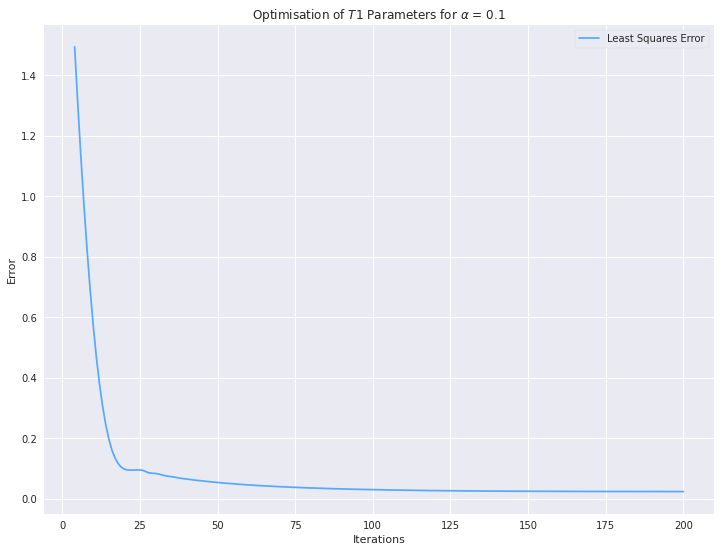

In [75]:
%matplotlib inline
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(12, 9))

plt.plot(tlst[4:], scorelst[4:], label = 'Least Squares Error', color = cool[1])

plt.title('Optimisation of $T1$ Parameters for ' + r'$\alpha$' + ' = ' + str(alpha))
plt.xlabel('Iterations')
plt.ylabel('Error')
# plt.ylim(-0.05, 1.05)
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

In [76]:
# rows_adam = zip(tlst, scorelst)

# with open('adam_optimisation.csv', "w") as a:
#     writer = csv.writer(a)
#     for row in rows_adam:
#         writer.writerow(row)

## Plot the fitted results

In [77]:
t1_best = func_t1(xd, *best)

In [78]:
#R2 Regression

np.round(reg([jnp.array(t1mit_lst11, dtype=jnp.float64), jnp.array(t1mit_lst01, dtype=jnp.float64), jnp.array(t1mit_lst10, dtype=jnp.float64), jnp.array(t1mit_lst00, dtype=jnp.float64)],
    [t1_best[:, 0, 0], t1_best[:, 1, 1], t1_best[:, 2, 2], t1_best[:, 3, 3]]), 2)

DeviceArray(99.89, dtype=float32)

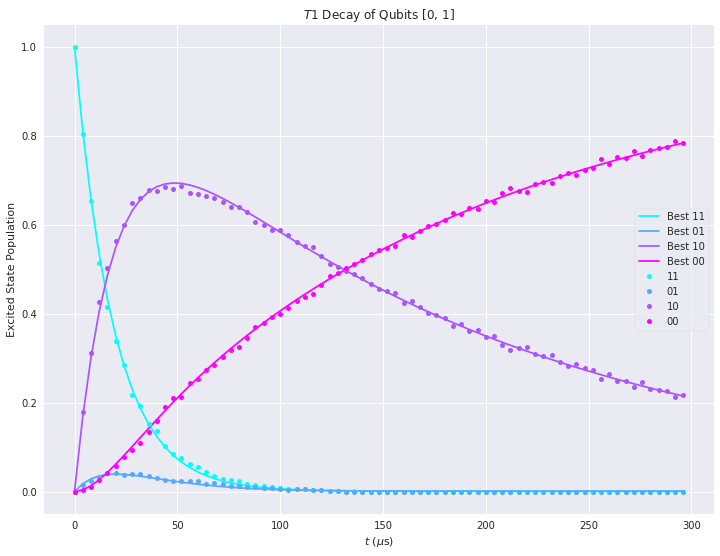

In [79]:
%matplotlib inline
plt.style.use('seaborn')
# matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
fig, ax = plt.subplots(figsize=(12, 9))

plt.plot(time, t1_best[:, 0, 0], label = 'Best 11', color = cool[0])
plt.plot(time, t1_best[:, 1, 1], label = 'Best 01', color = cool[1])
plt.plot(time, t1_best[:, 2, 2], label = 'Best 10', color = cool[2])
plt.plot(time, t1_best[:, 3, 3], label = 'Best 00', color = cool[3])
plt.plot(time, t1mit_lst11, label = '11', marker='.', markersize=10, linestyle='', color = cool[0])
plt.plot(time, t1mit_lst01, label = '01', marker='.', markersize=10, linestyle='', color = cool[1])
plt.plot(time, t1mit_lst10, label = '10', marker='.', markersize=10, linestyle='', color = cool[2])
plt.plot(time, t1mit_lst00, label = '00', marker='.', markersize=10, linestyle='', color = cool[3])

plt.title(f'$T1$ Decay of Qubits {qubits}')
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('Excited State Population')
plt.ylim(-0.05, 1.05)
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

## Same now for $T_2$ Echo

In [80]:
def minmse2(y):
    Y = y[0]
    
    rhot2s = func_t2e(xd * 1.3, *Y)
    
    t1data = jnp.array(t2emit_lst00, dtype=jnp.float64)
    t2data = jnp.array(t2emit_lst10, dtype=jnp.float64)
    t3data = jnp.array(t2emit_lst01, dtype=jnp.float64)
    t4data = jnp.array(t2emit_lst11, dtype=jnp.float64)
    tdata = [t1data, t2data, t3data, t4data]
    
    tst1 = rhot2s[:, 0, 0]
    tst2 = rhot2s[:, 1, 1]
    tst3 = rhot2s[:, 2, 2]
    tst4 = rhot2s[:, 3, 3]
    tstd = [tst1, tst2, tst3, tst4]
    
    return mse(tdata, tstd)

In [81]:
minmse2([prmsl_hc])

DeviceArray(0.39322776, dtype=float32)

In [82]:
# Define an adam gradient descent optimiser

minfunc = vmap(minmse2)

scorelst = []
tlst = []

# bounds = jnp.array([w0, w1, g2l[0], g2l[1], j01, n1, n2], dtype = jnp.float32)

def adam_jack2(bounds, n_iter, alpha, beta1, beta2, eps=1e-8):
    x = bounds
    first = x
    best = x
    worst = x
    score = minfunc(jnp.array([[x]]))
    scbest = score
    print('f(%s) = %f' % (x, score))
    
    J = jacrev(minmse2)
    
    m = jnp.array([0, 0, 0, 0, 0, 0, 0], dtype = jnp.float32)
    v = jnp.array([0, 0, 0, 0, 0, 0, 0], dtype = jnp.float32)
    
    for t in range(n_iter + 1):
        # calculate gradient g(t)
        g = J([x])[0]
        
        m = beta1 * m + (1.0 - beta1) * g
        v = beta2 * v + (1.0 - beta2) * g**2
        
        mhat = m / (1.0 - beta1**(t+1))
        vhat = v / (1.0 - beta2**(t+1))
        
        x = x - alpha * mhat / (sqrt(vhat) + eps)
        
        for i in range(len(x)):
            if x[i] < 0:
                # x = index_update(x, index[i], bounds[i])
                x = x.at[i].set(bounds[i])
        
        if scbest > minmse2(jnp.array([x])):
            best = x
            scbest = minmse2(jnp.array([best]))
        
        # evaluate candidate point
        score = minfunc(jnp.array([[x]]))
        scorelst.append(score)
        tlst.append(t)
        print('>%d => %f' % (t, score))
    return [best, scbest, first]

In [83]:
# bnds2 = best2
bnds2 = prmsl_hc
# bnds2 = jnp.array([g2l[0] * 1e-3, g2l[1] * 1e-3, j01 * 1e-3, N1, N2])

In [84]:
# Run the gradient descent algorithm

# define the total iterations
n_iter = 500
# steps size
alpha = 0.1
# factor for average gradient
beta1 = 0.8
# factor for average squared gradient
beta2 = 0.999
# perform the gradient descent search with adam
best2, score2, worst = adam_jack2(bnds2, n_iter, alpha, beta1, beta2)
print('Done!')
print('f(%s) = %f' % (best2, score2))

f([3.9873474e+01 6.9754272e+00 0.0000000e+00 0.0000000e+00 7.3781059e+01
 1.9233901e-16 3.7564183e-16]) = 0.393228


2022-05-28 11:23:49.744963: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:61] 
********************************
Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
Compiling module jit_backward_pass.404
********************************


>0 => 0.386810
>1 => 0.383159
>2 => 0.380191
>3 => 0.379129
>4 => 0.377798
>5 => 0.376124
>6 => 0.374187
>7 => 0.372366
>8 => 0.371043
>9 => 0.369842
>10 => 0.368895
>11 => 0.367817
>12 => 0.366597
>13 => 0.365282
>14 => 0.364038
>15 => 0.362895
>16 => 0.361739
>17 => 0.360561
>18 => 0.359357
>19 => 0.358138
>20 => 0.356919
>21 => 0.355836
>22 => 0.354693
>23 => 0.353494
>24 => 0.352277
>25 => 0.351161
>26 => 0.350039
>27 => 0.348871
>28 => 0.347725
>29 => 0.346625
>30 => 0.345522
>31 => 0.344440
>32 => 0.343415
>33 => 0.342338
>34 => 0.341220
>35 => 0.340302
>36 => 0.339182
>37 => 0.338269
>38 => 0.337353
>39 => 0.336334
>40 => 0.335228
>41 => 0.334393
>42 => 0.333277
>43 => 0.332496
>44 => 0.331594
>45 => 0.330556
>46 => 0.329601
>47 => 0.328777
>48 => 0.327773
>49 => 0.326958
>50 => 0.326036
>51 => 0.325168
>52 => 0.324296
>53 => 0.323451
>54 => 0.322597
>55 => 0.321808
>56 => 0.321196
>57 => 0.320135
>58 => 0.319302
>59 => 0.318436
>60 => 0.317650
>61 => 0.316832
>62 => 0.316153
>6

0.072405

In [85]:
t2e_best = func_t2e(xd * 1.3, *best2)

In [86]:
#R2 Regression

np.round(reg([jnp.array(t2emit_lst00, dtype=jnp.float64), jnp.array(t2emit_lst10, dtype=jnp.float64), jnp.array(t2emit_lst01, dtype=jnp.float64), jnp.array(t2emit_lst11, dtype=jnp.float64)],
    [t2e_best[:, 0, 0], t2e_best[:, 1, 1], t2e_best[:, 2, 2], t2e_best[:, 3, 3]]), 2)

DeviceArray(95.32, dtype=float32)

98.26

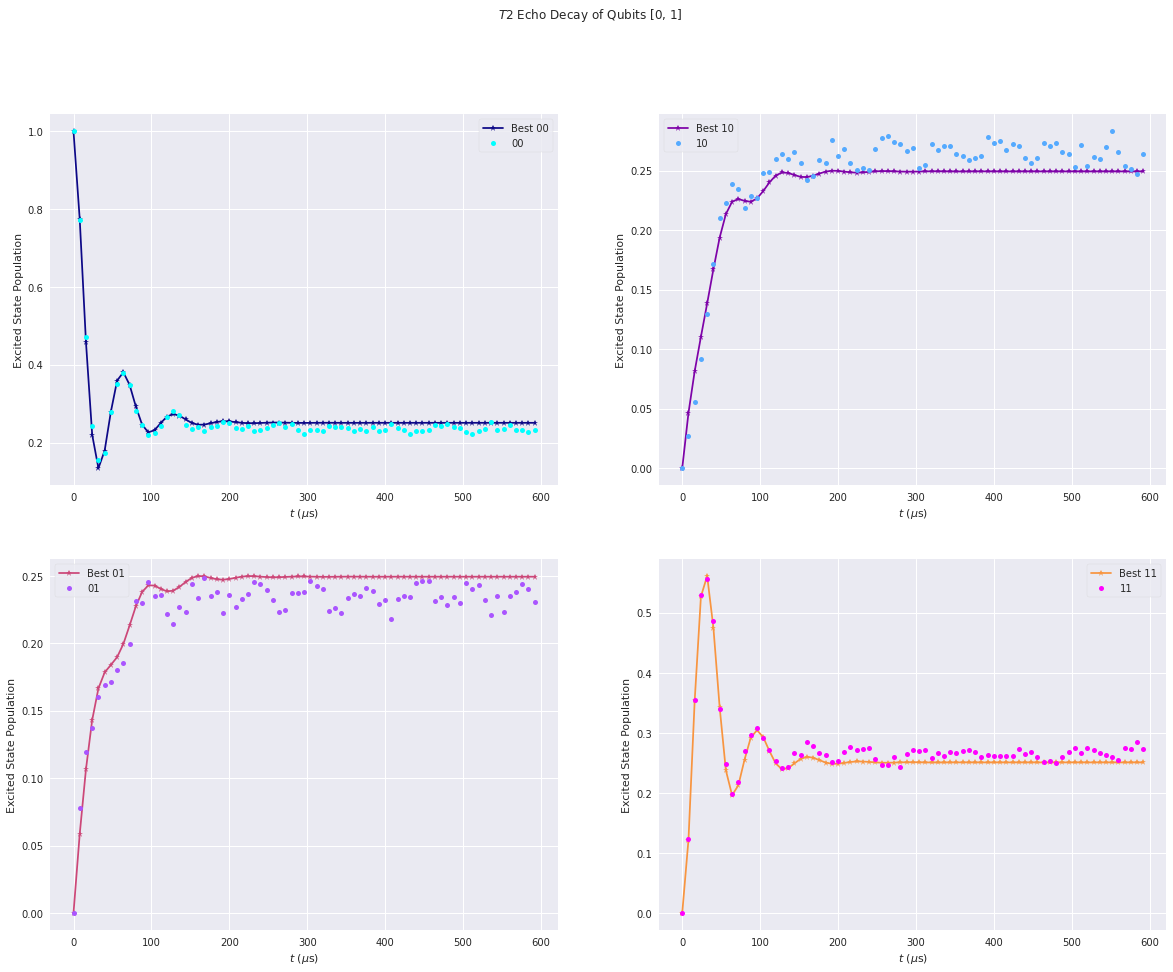

In [87]:
%matplotlib inline
plt.style.use('seaborn')
# matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

# plt.errorbar(time, t2emit_lst00, t1ystd00, label = "00", marker='.', linestyle = '', markersize=10, c = cool[0])
# plt.errorbar(time, t2emit_lst10, t1ystd10, label = "10", marker='.', linestyle = '', markersize=10, c = cool[1])
# plt.errorbar(time, t2emit_lst01, t1ystd01, label = "01", marker='.', linestyle = '', markersize=10, c = cool[2])
# plt.errorbar(time, t2emit_lst11, t1ystd11, label = "11", marker='.', linestyle = '', markersize=10, c = cool[3])

# ax[0, 0].errorbar(time, t2emit_lst00, t1ystd00, label = "00", marker='.', linestyle = '', markersize=10, c = cool[0])
# ax[0, 1].errorbar(time, t2emit_lst10, t1ystd10, label = "10", marker='.', linestyle = '', markersize=10, c = cool[1])
# ax[1, 0].errorbar(time, t2emit_lst01, t1ystd01, label = "01", marker='.', linestyle = '', markersize=10, c = cool[2])
# ax[1, 1].errorbar(time, t2emit_lst11, t1ystd11, label = "11", marker='.', linestyle = '', markersize=10, c = cool[3])

# plt.plot(time, t2e_best[:, 0, 0], label = 'Best 00', marker='*', color = plasma[0])
# plt.plot(time, t2e_best[:, 1, 1], label = 'Best 10', marker='*', color = plasma[1])
# plt.plot(time, t2e_best[:, 2, 2], label = 'Best 01', marker='*', color = plasma[2])
# plt.plot(time, t2e_best[:, 3, 3], label = 'Best 11', marker='*', color = plasma[3])

ax[0, 0].plot(time * 2, t2e_best[:, 0, 0], label = 'Best 00', marker='*', color = plasma[0])
ax[0, 1].plot(time * 2, t2e_best[:, 1, 1], label = 'Best 10', marker='*', color = plasma[1])
ax[1, 0].plot(time * 2, t2e_best[:, 2, 2], label = 'Best 01', marker='*', color = plasma[2])
ax[1, 1].plot(time * 2, t2e_best[:, 3, 3], label = 'Best 11', marker='*', color = plasma[3])

ax[0, 0].plot(time * 2, t2emit_lst00, label = "00", marker='.', linestyle = '', markersize=10, c = cool[0])
ax[0, 1].plot(time * 2, t2emit_lst10, label = "10", marker='.', linestyle = '', markersize=10, c = cool[1])
ax[1, 0].plot(time * 2, t2emit_lst01, label = "01", marker='.', linestyle = '', markersize=10, c = cool[2])
ax[1, 1].plot(time * 2, t2emit_lst11, label = "11", marker='.', linestyle = '', markersize=10, c = cool[3])

fig.suptitle(f'$T2$ Echo Decay of Qubits {qubits}')

for a in ax.flat:
    a.set(xlabel='$t$ ($\mu$s)', ylabel='Excited State Population')

# Hide x labels and tick labels for top plots and y ticks for right plots.
# for b in ax.flat:
#     b.label_outer()

# fig.xlabel('$t$ ($\mu$s)')
# fig.ylabel('Excited State Population')
# plt.ylim(-0.05, 1.05)

ax[0, 0].legend(loc = "best",numpoints=1,frameon=True)
ax[0, 1].legend(loc = "best",numpoints=1,frameon=True)
ax[1, 0].legend(loc = "best",numpoints=1,frameon=True)
ax[1, 1].legend(loc = "best",numpoints=1,frameon=True)

plt.show()

In [88]:
# rows_t2eb_00 = zip(time*2, t2e_best[:, 0, 0])
# rows_t2eb_10 = zip(time*2, t2e_best[:, 1, 1])
# rows_t2eb_01 = zip(time*2, t2e_best[:, 2, 2])
# rows_t2eb_11 = zip(time*2, t2e_best[:, 3, 3])

# with open('Q2_T2e_best00.csv', "w") as a:
#     writer = csv.writer(a)
#     for row in rows_t2eb_00:
#         writer.writerow(row)

# with open('Q2_T2e_best10.csv', "w") as a:
#     writer = csv.writer(a)
#     for row in rows_t2eb_10:
#         writer.writerow(row)

# with open('Q2_T2e_best01.csv', "w") as a:
#     writer = csv.writer(a)
#     for row in rows_t2eb_01:
#         writer.writerow(row)

# with open('Q2_T2e_best11.csv', "w") as a:
#     writer = csv.writer(a)
#     for row in rows_t2eb_11:
#         writer.writerow(row)

## Extract Parameters

In [89]:
best

DeviceArray([4.7042542e+01, 5.2248373e+00, 2.3209569e+00, 2.3209569e+00,
             6.1167595e-03, 1.5463429e-03, 1.6710442e-02], dtype=float32)

In [90]:
best2

DeviceArray([1.4698982e+01, 3.5931892e+00, 2.5979750e+00, 0.0000000e+00,
             7.4179245e+01, 1.9233901e-16, 2.3228676e+00], dtype=float32)

10.10989, 12.246543, 81.14675, 0.08668155, 1.4380418

In [91]:
# W0 = best[0]
# W1 = best[1]

N1 = best[-2]
N2 = best[-1]

T1 = T(w0, N1).to(unts.mK)
T2 = T(w1, N2).to(unts.mK)

G1 = best[0]
G2 = best[1]

T10 = 1/G1 * unts.ms
T11 = 1/G2 * unts.ms

Gz1 = best[2]
Gz2 = best[3]

Tz10 = 1/Gz1 * unts.ms
Tz11 = 1/Gz2 * unts.ms


In [92]:
w1 / 1e9 * unts.GHz

<Quantity 29.05376929 GHz>

In [93]:
w2 / 1e9 * unts.GHz

<Quantity 30.28676699 GHz>

In [94]:
T1

<Quantity 35.83276272 mK>

In [95]:
T2

<Quantity 54.01741713 mK>

In [96]:
T10.to(unts.us)

<Quantity 21.25735581 us>

In [97]:
T11.to(unts.us)

<Quantity 191.39352441 us>

In [98]:
Tz10.to(unts.us)

<Quantity 430.85676432 us>

In [99]:
Tz11.to(unts.us)

<Quantity 430.85676432 us>

In [100]:
float(jnp.abs(j01 * 1e-9 - best[2])/(j01 * 1e-9))

313.5735778808594

In [101]:
j01 * 1e-7

0.7378105608801838

In [102]:
best[2]

DeviceArray(2.320957, dtype=float32)

In [103]:
(t1c * unts.s).to(unts.us)

<Quantity [ 25.079329, 143.3604  , 136.55504 , 167.1539  , 136.4323  ] us>

In [104]:
# Now for T2 Echo

N1e = best2[-2]
N2e = best2[-1]

T1e = T(w0, N1e).to(unts.mK)
T2e = T(w1, N2e).to(unts.mK)

G1e = best2[0]
G2e = best2[1]

T10e = 1/G1e * unts.ms
T11e = 1/G2e * unts.ms

Gz1e = best2[2]
Gz2e = best2[3]

Tz10e = 1/Gz1e * unts.ms
Tz11e = 1/Gz2e * unts.ms

In [105]:
float(jnp.abs(j01 / 1e5 - best2[2])/(j01 / 1e5))

0.964788019657135

In [106]:
T1e

<Quantity 6.40999107 mK>

In [107]:
T2e

<Quantity 619.84217167 mK>

In [108]:
T10e.to(unts.us)

<Quantity 68.03192198 us>

91.015182 us

In [109]:
T11e.to(unts.us)

<Quantity 278.30430865 us>

157.24927 us

In [110]:
Tz10e.to(unts.us)

<Quantity 384.91517305 us>

313.33083 us

In [111]:
Tz11e.to(unts.us)

<Quantity inf us>

3891.2129 us

In [112]:
(t2c * unts.s).to(unts.us)

<Quantity [ 54.660965,  99.02356 ,  66.012184, 113.83765 , 134.01836 ] us>

[148.20224, 113.13173, 65.840096, 134.70735, 96.53685] us

In [113]:
import qiskit.tools.jupyter
%qiskit_version_table